In [2]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    matplotlib.pyplot.scatter(df.iloc[row_num,:], time)
      


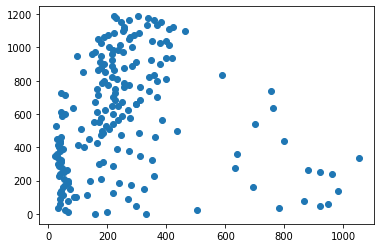

In [3]:
s745_df = get_normed_and_zero_filtered_data("data/sub_0745_miRNA.ec.tab")
s745_time = get_s745_time(s745_df.columns)
s814_df = get_normed_and_zero_filtered_data("data/sub_0814_miRNA.ec.tab")

plot_one_row_scatter(s745_df, 1,s745_time )


In [18]:
 
s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)

sc.pp.highly_variable_genes(s814_adata, n_top_genes=50)
# sc.pl.highest_expr_genes(s814_adata, n_top=30, )


s814_pd = get_periodgram(s814_adata[:,s814_adata.var.highly_variable]) 
s814_pd_array = np.array([i[1] for i in s814_pd])
np_array =np.array(s814_pd)
#print(np_array.shape)
#print(s814_pd_array.shape)



(50, 2, 49)


In [15]:

def dist(x, y):
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 30):


    centroids = pd[np.random.choice(pd.shape[0], K)]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
    return centroids

   
   



In [43]:
K = 6
centroids = k_means_from_pd_data(s814_pd_array,K)

print('centroids = \n', centroids)

centroids = 
 [[9.68459904e-13 1.80603647e+00 1.97867191e+00 9.43738401e-01
  1.56929147e+00 1.09399164e+00 5.68999231e-01 1.47077620e+00
  7.78008163e-01 1.30033207e+00 1.63259315e+00 9.43342865e-01
  1.65175343e+00 1.29539752e+00 2.00089383e+00 1.52308452e+00
  1.26061952e+00 1.16493762e+00 1.65616035e+00 5.77129781e-01
  1.59163570e+00 9.43272591e-01 1.46000671e+00 1.02696466e+00
  7.31176376e-01 8.74704540e-01 6.25406682e-01 1.04964387e+00
  1.92420483e+00 6.55029356e-01 2.63807327e-01 1.12982833e+00
  1.03281701e+00 1.93712080e+00 1.01800203e+00 6.61638319e-01
  9.94684935e-01 1.56715333e+00 1.31440258e+00 2.49166489e+00
  2.81131744e+00 1.53915703e+00 1.18459833e+00 1.94333398e+00
  5.80040634e-01 1.48257911e+00 1.35681725e+00 7.48873532e-01
  4.28221941e-01]
 [3.30698468e-13 2.19321632e+00 2.13459277e+00 2.38203502e+00
  2.96065664e+00 2.09835434e+00 3.57596588e+00 3.27968740e+00
  2.95863509e+00 2.96812654e+00 1.83436656e+00 1.62120295e+00
  4.68607092e+00 1.74154270e+00 2.4501

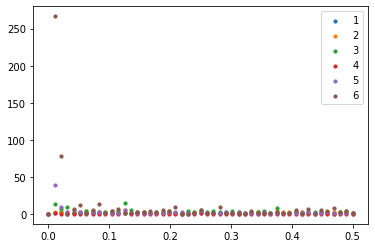

In [44]:
import matplotlib.pyplot as plt
#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0],centroids[i], s=10, label=i+1)

plt.legend();
plt.show();


In [45]:
#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))